# MNIST
- MNIST: 手書き数字を読み取るタスク
- タスクはクラス識別に分類できる
- 0~9までの数字（ラベル）があるため、10種類のクラスの中から一つのクラスを予測する

## 1. Importと定数定義

In [1]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import wandb
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [2]:
BATCH_SIZE = 256
LR = 1e-3
NUM_WORKERS = 4
EPOCHS = 20

## 2. Datasetsを読み込む

In [3]:
# 学習用データセット
train_datasets = datasets.MNIST(
    "data/",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomAutocontrast(),
        transforms.Normalize(
            mean=[0],
            std=[1],
        ),
    ])
)
# 検証用データセット
val_datasets = datasets.MNIST(
    "data/",
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0],
            std=[1],
        ),
    ])
)

## 3. Modelの用意

In [4]:
class Model(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),            
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(128, 512, kernel_size=3),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),            
        )
        self.fc1 = nn.Linear(
            12 * 12 * 512,
            64
        )
        self.fc2 = nn.Linear(
            64,
            10
        )
        self.activation = nn.LogSoftmax(dim=1)
        
    def forward(self, x: torch.Tensor):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view((-1, 12 * 12 * 512))
        x = self.fc1(x)
        x = self.fc2(x)
        out = self.activation(x)
        return out

### ネットワークの確認（任意）
今回MNISTは28×28pxなので同様の形状でネットワークに入力をして、出力が(BATCH_SIZE, 10)の形状のテンソルであることを確認する

In [5]:
# torch.randは[0, 1)で値を返すので255で掛け算する
input_image, input_label = train_datasets[100]
input_image.shape

torch.Size([1, 28, 28])

In [6]:
input_label = torch.tensor([input_label])

In [7]:
imgs = input_image.unsqueeze(dim=0)
labels = input_label.unsqueeze(dim=0)
model = Model()
outs = model(imgs)
outs

tensor([[-2.2397, -2.1697, -2.2883, -2.2046, -2.3275, -1.9658, -2.8696, -2.7290,
         -2.4263, -2.1235]], grad_fn=<LogSoftmaxBackward0>)

nn.Softmaxの出力は各ラベルの確率なので合計すると1になる

In [8]:
torch.sum(outs)

tensor(-23.3440, grad_fn=<SumBackward0>)

学習をしていない状態での予測結果を確認

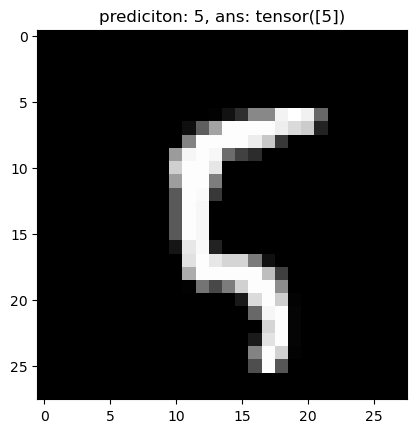

In [9]:
predict_label = torch.argmax(outs, dim=1)[0].item()
img = input_image.permute((1, 2, 0)).numpy()
plt.imshow(img, cmap="gray")
plt.title(f"prediciton: {predict_label}, ans: {input_label}")
plt.show()

## 4.学習 & 検証

### 学習に必要な要素の準備

In [10]:
# デバイス
device = torch.device("cuda")

# 深層学習モデル
model = Model()
model = nn.DataParallel(model)
model = model.to(device)

# 損失関数
loss_fn = nn.NLLLoss() # nn.LogSoftmax + nn.NLLLoss == 交差クロスエントロピー

# 最適化関数
optimizer = optim.Adam(model.parameters(), lr=LR)

# 学習率スケジューラ
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=EPOCHS,
    verbose=True,
)

# データローダ
# 学習用
train_dataloader = DataLoader(
    train_datasets,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True,
)
# 検証用
val_dataloader = DataLoader(
    val_datasets,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False,
)

Adjusting learning rate of group 0 to 1.0000e-03.


### 学習 & 検証

In [11]:
results = [
    {
        "train": {},
        "val": {}
    } for i in range(EPOCHS)
]

In [12]:
for epoch in tqdm(range(EPOCHS)):
    model.train()
    epoch_loss = 0
    correct_counts = 0
    for imgs, labels in tqdm(train_dataloader, leave=False):        
        optimizer.zero_grad()
        imgs = imgs.to(device)
        labels = labels.to(device)
        outs = model(imgs)
        loss = loss_fn(outs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()    
        preds = torch.argmax(outs, dim=1)
        correct_counts += (preds == labels).sum().item()
    lr_scheduler.step()
    acc = correct_counts / len(train_datasets)
    print(f"epoch: {epoch}, train loss: {epoch_loss:.3f}. train acc: {acc:.3f}")
    results[epoch]["train"]["acc"] = acc
    results[epoch]["train"]["loss"] = epoch_loss
    with torch.no_grad():
        model.eval()
        correct_counts = 0
        for imgs, labels in tqdm(val_dataloader, leave=False):
            imgs = imgs.to(device)
            labels = labels.to(device)
            outs = model(imgs)
            preds = torch.argmax(outs, dim=1)
            correct_counts += (preds == labels).sum().item()
        acc = correct_counts / len(val_datasets)
        print(f"epoch: {epoch}, val acc: {acc:.3f}")
        results[epoch]["val"]["acc"] = acc

  0%|          | 0/20 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.9384e-04.
epoch: 0, train loss: 534.290. train acc: 0.758


  5%|▌         | 1/20 [00:15<05:01, 15.85s/it]

epoch: 0, val acc: 0.898


Adjusting learning rate of group 0 to 9.7553e-04.
epoch: 1, train loss: 102.317. train acc: 0.884


 10%|█         | 2/20 [00:21<03:01, 10.10s/it]

epoch: 1, val acc: 0.879


Adjusting learning rate of group 0 to 9.4550e-04.
epoch: 2, train loss: 81.119. train acc: 0.906


 15%|█▌        | 3/20 [00:28<02:20,  8.28s/it]

epoch: 2, val acc: 0.903


Adjusting learning rate of group 0 to 9.0451e-04.
epoch: 3, train loss: 65.278. train acc: 0.921


 20%|██        | 4/20 [00:34<01:58,  7.41s/it]

epoch: 3, val acc: 0.921


Adjusting learning rate of group 0 to 8.5355e-04.
epoch: 4, train loss: 56.703. train acc: 0.930


 25%|██▌       | 5/20 [00:40<01:44,  6.94s/it]

epoch: 4, val acc: 0.924


Adjusting learning rate of group 0 to 7.9389e-04.
epoch: 5, train loss: 46.763. train acc: 0.940


 30%|███       | 6/20 [00:46<01:32,  6.64s/it]

epoch: 5, val acc: 0.951


Adjusting learning rate of group 0 to 7.2700e-04.
epoch: 6, train loss: 38.547. train acc: 0.949


 35%|███▌      | 7/20 [00:52<01:24,  6.47s/it]

epoch: 6, val acc: 0.945


Adjusting learning rate of group 0 to 6.5451e-04.
epoch: 7, train loss: 35.214. train acc: 0.953


 40%|████      | 8/20 [00:58<01:16,  6.36s/it]

epoch: 7, val acc: 0.948


Adjusting learning rate of group 0 to 5.7822e-04.
epoch: 8, train loss: 31.421. train acc: 0.957


 45%|████▌     | 9/20 [01:04<01:08,  6.26s/it]

epoch: 8, val acc: 0.942


Adjusting learning rate of group 0 to 5.0000e-04.
epoch: 9, train loss: 28.488. train acc: 0.961


 50%|█████     | 10/20 [01:10<01:02,  6.21s/it]

epoch: 9, val acc: 0.950


Adjusting learning rate of group 0 to 4.2178e-04.
epoch: 10, train loss: 26.755. train acc: 0.963


 55%|█████▌    | 11/20 [01:16<00:55,  6.16s/it]

epoch: 10, val acc: 0.953


Adjusting learning rate of group 0 to 3.4549e-04.
epoch: 11, train loss: 24.117. train acc: 0.967


 60%|██████    | 12/20 [01:22<00:49,  6.15s/it]

epoch: 11, val acc: 0.955


Adjusting learning rate of group 0 to 2.7300e-04.
epoch: 12, train loss: 20.925. train acc: 0.971


 65%|██████▌   | 13/20 [01:28<00:42,  6.13s/it]

epoch: 12, val acc: 0.959


Adjusting learning rate of group 0 to 2.0611e-04.
epoch: 13, train loss: 18.223. train acc: 0.976


 70%|███████   | 14/20 [01:35<00:36,  6.12s/it]

epoch: 13, val acc: 0.955


Adjusting learning rate of group 0 to 1.4645e-04.
epoch: 14, train loss: 16.399. train acc: 0.978


 75%|███████▌  | 15/20 [01:41<00:30,  6.11s/it]

epoch: 14, val acc: 0.959


Adjusting learning rate of group 0 to 9.5492e-05.
epoch: 15, train loss: 14.628. train acc: 0.980


 80%|████████  | 16/20 [01:47<00:24,  6.11s/it]

epoch: 15, val acc: 0.958


Adjusting learning rate of group 0 to 5.4497e-05.
epoch: 16, train loss: 13.460. train acc: 0.983


 85%|████████▌ | 17/20 [01:53<00:18,  6.10s/it]

epoch: 16, val acc: 0.963


Adjusting learning rate of group 0 to 2.4472e-05.
epoch: 17, train loss: 11.816. train acc: 0.985


 90%|█████████ | 18/20 [01:59<00:12,  6.07s/it]

epoch: 17, val acc: 0.963


Adjusting learning rate of group 0 to 6.1558e-06.
epoch: 18, train loss: 11.290. train acc: 0.986


 95%|█████████▌| 19/20 [02:05<00:06,  6.04s/it]

epoch: 18, val acc: 0.964


Adjusting learning rate of group 0 to 0.0000e+00.
epoch: 19, train loss: 10.577. train acc: 0.987


100%|██████████| 20/20 [02:11<00:00,  6.57s/it]

epoch: 19, val acc: 0.964


# 5.可視化

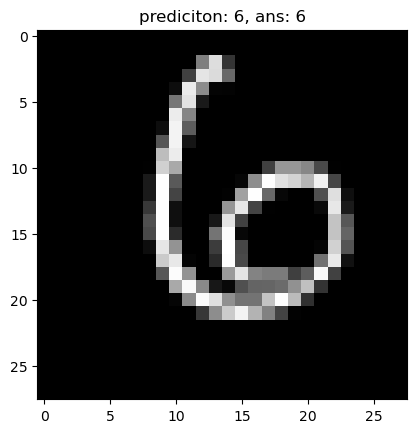

In [13]:
img, label = val_datasets[100]
outs = model(img.unsqueeze(dim=0))

predict_label = torch.argmax(outs, dim=1)[0].item()
img = img.permute((1, 2, 0)).numpy()
plt.imshow(img, cmap="gray")
plt.title(f"prediciton: {predict_label}, ans: {label}")
plt.show()

In [14]:
train_acc = []
train_loss = []
val_acc = []
for result in results:
    train_acc.append(result["train"]["acc"])
    train_loss.append(result["train"]["loss"])
    val_acc.append(result["val"]["acc"])

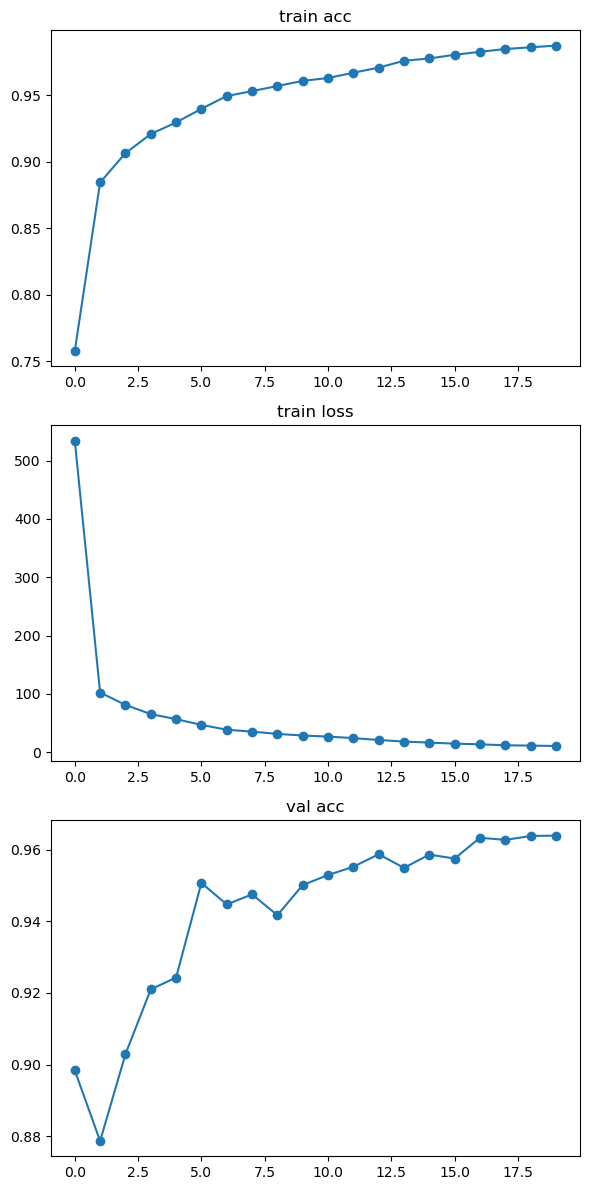

In [15]:
x = np.array(range(EPOCHS))
fig, axes = plt.subplots(3, 1, figsize=(6, 12))

axes[0].plot(x, train_acc, marker="o")
axes[0].set_title("train acc")
axes[1].plot(x, train_loss, marker="o")
axes[1].set_title("train loss")
axes[2].plot(x, val_acc, marker="o")
axes[2].set_title("val acc")
fig.tight_layout()
fig.show()